# Otimização de Lavra Mineral através do Sequenciamento Direto de Blocos.
Por: Thalles Morais

Este notebook refere-se a um modelo de otimização de lavra a qual foi modelada de acordo com o modelo de blocos. Os dados usados como input neste notebook estão em uma tabela de 500 linhas onde cada linha possui informações de um bloco, onde todos os 500 blocos preenchem a região onde se interessa extrair minério. 

O objetivo deste notebook é criar um algoritmo que retorne a sequência de blocos a serem extraídos por período que apresente maior lucro, considerando restrições de capacidade de lavra, capacidade de usina e precedência de blocos. As restrições de capacidade de lavra e usina estão relacionadas à tonelagem de massa que podem ser lavradas e processadas em um ano e a restrição de precedência de bloco diz quais blocos devem ser extraídos para que outro também seja (considerando que alguns blocos estão posicionados em cima de outros).

In [19]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import miningpy

As colunas da tabela usada neste notebook referem-se às informações que cada bloco possui como massa, teor e suas coordenadas no espaço. Essas informações são fundamentais para determinar se um bloco deve ou não ser extraído e, caso seja, se ele deve ser destinado à usina ou para a pilha de estéril. 

In [20]:
df = pd.read_excel(r'C:\Users\thall\Documents\Faculdade\Iniciação_Científica\Sequenciamento\dataset2.xlsx')
df = df[['ID', 'IX', 'IY', 'IZ', 'Massa', 'Densidade', 'Teor']]
df.head()

,ID,IX,IY,IZ,Massa,Densidade,Teor
0,1,1,1,5,2850,2.85,0.0
1,2,2,1,5,2850,2.85,0.0
2,3,3,1,5,2850,2.85,0.0
3,4,4,1,5,2850,2.85,0.0
4,5,5,1,5,2850,2.85,0.0


In [21]:
ID = list(df['ID'].values)
i = list(df['IX'].values)
j = list(df['IY'].values)
k = list(df['IZ'].values)
Massa = list(df['Massa'].values)
Densidade = list(df['Densidade'].values)
Teor = list(df['Teor'].values)

comprimento = max(i)
largura = max(j)
altura = max(k)
area = comprimento*largura
volume = comprimento*largura*altura

As listas criadas abaixo estão relacionadas com as restrições de precedência de blocos, isto é, cada lista refere-se a uma posição de um bloco b1 em relação ao bloco b0, onde cada bloco de cada lista é testado como bloco b0. Para um bloco b0, existem cinco possíveis blocos b1 a serem removidos anteriormente, se um bloco está em determinada lista abaixo, o bloco b1 referente à posição desta lista deve ser removido.

In [22]:
lista_todos_valores = []
for zuppo in range(area+1, volume+1):
    lista_todos_valores.append(zuppo)

lista_primeira_linha = []
for I in lista_todos_valores:
    if I % area > 10 or I % area == 0:
        lista_primeira_linha.append(I)

lista_ultima_linha = []
for s in lista_todos_valores:
    if s % area <= 90 and s % area != 0:
        lista_ultima_linha.append(s)        

lista_primeira_coluna = []
for a in lista_todos_valores:
    if a % comprimento != 1:
        lista_primeira_coluna.append(a)
        
lista_última_coluna = []
for d in lista_todos_valores:
    if d % comprimento != 0:
        lista_última_coluna.append(d)
        
lista_diag_sup_esq = []
for o in lista_primeira_linha:
    if o % 10 != 1:
        lista_diag_sup_esq.append(o)

lista_diag_inf_esq = []
for r in lista_ultima_linha:
    if r % 10 != 1:
        lista_diag_inf_esq.append(r)
        
lista_diag_sup_dir = []
for a in lista_primeira_linha:
    if a % 10 != 0:
        lista_diag_sup_dir.append(a)
        
lista_diag_inf_dir = []
for x in lista_ultima_linha:
    if x % 10 != 0:
        lista_diag_inf_dir.append(x)

As informações abaixo dizem respeito aos parâmetros econômicos do cenário considerado, onde:
    
• Custo por tonelada lavrada: $ 1

• Custo por tonelada processada: $ 4

• Custo por tonelada do produto final: $ 1488,12

• Preço por tonelada do produto final: $ 6576,38

• Taxa de desconto: 10%

• Recuperação de minério no processamento: 88%

Para determinar quais blocos podem ser enviados para a usina e quais não, foi utilizada a função benefício representada pela equação:


# 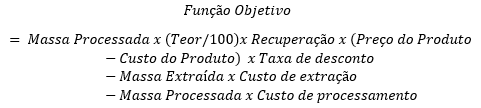

Todos os 500 blocos são testados nessa função onde se o seu valor for positivo o bloco, caso lavrado, é destinado para usina, caso contrário, destinado para a pilha de estéril.

In [23]:
Custo_Mina = 1.00
Custo_Usina = 4.00
Custo_Produto = 1488.12
Preço_minério = 6576.38
Taxa_de_desconto = 10.00
Recuperação = 0.88
ano = 1
Massa_Processada = []
Lucro_Prejuízo = []

for num in range(int(volume)):
    lucro_prejuízo = (Massa[num]*(Teor[num]/100)*Recuperação*(Preço_minério-Custo_Produto) - Massa[num]*Custo_Mina - Massa[num]*Custo_Usina)*(1/(1+(Taxa_de_desconto/100)**ano))
    Lucro_Prejuízo.append(lucro_prejuízo)
    if lucro_prejuízo > 0:
        massa_processada = Massa[num]
    else:
        massa_processada = 0
    Massa_Processada.append(massa_processada)
    
Lucro_Prej = []
for xuxu in range(int(volume)):
    lucro_prej = (Massa_Processada[xuxu]*Teor[xuxu]/100*Recuperação*(Preço_minério-Custo_Produto) - Massa[xuxu]*Custo_Mina - Massa_Processada[xuxu]*Custo_Usina)*(1/(1+(Taxa_de_desconto/100)**ano))
    Lucro_Prej.append(lucro_prej)
    
df['Massa Processada'] = Massa_Processada
df['Lucro/Prejuízo'] = Lucro_Prej

valores = list(df['Lucro/Prejuízo'].values)
df.head()

,ID,IX,IY,IZ,Massa,Densidade,Teor,Massa Processada,Lucro/Prejuízo
0,1,1,1,5,2850,2.85,0.0,0,-2590.909091
1,2,2,1,5,2850,2.85,0.0,0,-2590.909091
2,3,3,1,5,2850,2.85,0.0,0,-2590.909091
3,4,4,1,5,2850,2.85,0.0,0,-2590.909091
4,5,5,1,5,2850,2.85,0.0,0,-2590.909091


Os dicionários criados abaixo serão usados para definir as restrições anteriormente mencionadas.

In [24]:
dici_massa = {}
for d0, d1 in zip(range(1,volume+1),Massa):
    dici_massa[float(d0)] = d1
    
dici_min = {}
for m0, m1 in zip(range(1,volume+1),Massa_Processada):
    dici_min[float(m0)] = m1
    
Teor_min = {}
for t0, t1 in zip(range(1,volume+1), Teor):
    Teor_min[float(t0)] = t1

Através do algoritmo abaixo é possível visualizar a região de interesse modelada em blocos.

In [25]:
blockModelData = {
    'x' : i,
    'y' : j,
    'z' : k,
    'var' : valores
}

blockModel = pd.DataFrame(blockModelData)
blockModel.plot3D(
    xyz_cols=('x', 'y', 'z'),
    dims=(1, 1, 1),  
    col='var',
)

As linhas abaixo definem um período passivo de extração por 3 anos onde a cada ano é possível extrair 75.000 e processar 36.000 toneladas de massa.

In [26]:
blocks = ID
years = [3, 2, 1]
limit_mine = {3: 75000, 2: 75000, 1: 75000}
limit_process= {3: 36000, 2: 36000, 1: 36000} 
time_discount = {year: (1/(1+1/10.0)) ** (year) for year in years}

A célula abaixo define o modelo a ser otimizado. É criada a variável extract, a qual depende dos parâmetros blocos (blocks) e anos (years), e são definidas as 9 restrições, as quais estão relacionadas com as capacidades e precedências já mencionadas.

In [27]:
model = gp.Model('opencastMining')

extract = model.addVars(blocks, years, vtype=gp.GRB.BINARY, name="extract")
mined = model.addVars(years, name='mined')
processed = model.addVars(years, name='processed')

c1 = model.addConstrs(gp.quicksum(extract[b, year] for year in years) <= 1 for b in blocks)

c2 = model.addConstrs(gp.quicksum(extract[b, year] * dici_massa[b] for b in blocks) <= limit_mine[year] for year in years)

c3 = model.addConstrs(gp.quicksum(extract[b, year] * dici_min[b] for b in blocks) <= limit_process[year] for year in years)

b1 = model.addConstrs(gp.quicksum(extract[b, year] * dici_massa[b] for b in blocks) == mined[year] for year in years)

b2 = model.addConstrs(gp.quicksum(extract[b, year] * dici_min[b] for b in blocks) == processed[year] for year in years)

a1 = model.addConstrs((extract[b, current_year] <= gp.quicksum(extract[(b-area), next_year] for next_year in years[current_index - 3 :]) for b in blocks for current_index, current_year in enumerate(years) if b in lista_todos_valores))

a2 = model.addConstrs((extract[b, current_year] <= gp.quicksum(extract[(b-area-1), next_year] for next_year in years[current_index - 3 :]) for b in blocks for current_index, current_year in enumerate(years) if b in lista_primeira_coluna))

a3 = model.addConstrs((extract[b, current_year] <= gp.quicksum(extract[(b-area+1), next_year] for next_year in years[current_index - 3 :]) for b in blocks for current_index, current_year in enumerate(years) if b in lista_última_coluna))

a4 = model.addConstrs((extract[b, current_year] <= gp.quicksum(extract[(b-area-largura), next_year] for next_year in years[current_index - 3 :]) for b in blocks for current_index, current_year in enumerate(years) if b in lista_primeira_linha))

a5 = model.addConstrs((extract[b, current_year] <= gp.quicksum(extract[(b-area+largura), next_year] for next_year in years[current_index - 3 :]) for b in blocks for current_index, current_year in enumerate(years) if b in lista_ultima_linha))

#a6 = model.addConstrs((extract[b, current_year] <= gp.quicksum(extract[(b-area-largura+1), next_year] for next_year in years[current_index - 3 :]) for b in blocks for current_index, current_year in enumerate(years) if b in lista_diag_sup_dir))

#a7 = model.addConstrs((extract[b, current_year] <= gp.quicksum(extract[(b-area-largura-1), next_year] for next_year in years[current_index - 3 :]) for b in blocks for current_index, current_year in enumerate(years) if b in lista_diag_sup_esq))

#a8 = model.addConstrs((extract[b, current_year] <= gp.quicksum(extract[(b-area+largura+1), next_year] for next_year in years[current_index - 3 :]) for b in blocks for current_index, current_year in enumerate(years) if b in lista_diag_inf_dir))

#a9 = model.addConstrs((extract[b, current_year] <= gp.quicksum(extract[(b-area+largura-1), next_year] for next_year in years[current_index - 3 :]) for b in blocks for current_index, current_year in enumerate(years) if b in lista_diag_inf_esq))

O objetivo do otimizador é encontrar o maior valor resultado da função benefício variando o conjunto de blocos extraídos por ano.

In [28]:
extractionProfit = gp.quicksum(processed[year]*(Teor_min[b]/100)*0.88*(Preço_minério-Custo_Produto)*time_discount[year] for b in blocks for year in years) \
- gp.quicksum(mined[year]*Custo_Mina*time_discount[year] for year in years) - gp.quicksum(processed[year]*Custo_Usina*time_discount[year] for year in years)

model.setObjective(extractionProfit, sense=gp.GRB.MAXIMIZE)

In [29]:
model.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 6032 rows, 1506 columns and 21228 nonzeros
Model fingerprint: 0xf35823ba
Variable types: 6 continuous, 1500 integer (1500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [8e-01, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 4146 rows and 941 columns
Presolve time: 0.06s
Presolved: 1886 rows, 565 columns, 6308 nonzeros
Variable types: 0 continuous, 565 integer (565 binary)

Root relaxation: objective 3.664965e+07, 941 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3.6650e+07    0  377   -0.00000 3.6650e+07      -     -    0s
H    0     0                    1.143869e+07

O algoritmo abaixo retorna quais blocos devem ser extraídos por ano de acordo com o otimizador.

In [30]:
blocos_extraídos_ano1 = []
blocos_extraídos_ano2 = []
blocos_extraídos_ano3 = []
for year in years:
    print(year)
    for b in blocks:
        if round(extract[b, year].X) == 1:
            print(b, " ", end="")
            if year == 1:
                blocos_extraídos_ano1.append(b)
            if year == 2:
                blocos_extraídos_ano2.append(b)
            if year == 3:
                blocos_extraídos_ano3.append(b)
    print("\n")
    
blocos_extraídos_ano2 = sorted(blocos_extraídos_ano1 + blocos_extraídos_ano2)
blocos_extraídos_ano3 = sorted(blocos_extraídos_ano2 + blocos_extraídos_ano3)

3
16  25  27  34  38  43  49  52  126  135  137  144  148  153  236  245  247  254  256  346  355  

2
53  58  59  63  65  67  68  74  75  76  77  86  154  155  157  158  164  165  166  167  175  176  255  257  265  266  

1
26  35  36  37  44  45  46  47  48  54  55  56  57  64  66  85  136  145  146  147  156  246  



Visualização da região modelada após primeiro ano de lavra.

In [31]:
blocos_removidos = []
for bloco in blocos_extraídos_ano1:
    del i[bloco - len(blocos_removidos) - 1]
    del j[bloco - len(blocos_removidos) - 1]
    del k[bloco - len(blocos_removidos) - 1]
    del valores[bloco - len(blocos_removidos) - 1]
    blocos_removidos.append(bloco)

blockModelData = {
    'x' : i,
    'y' : j,
    'z' : k,
    'var' : valores
}

blockModel = pd.DataFrame(blockModelData)
blockModel.plot3D(
    xyz_cols=('x', 'y', 'z'),
    dims=(1, 1, 1),  
    col='var',
)

Visualização da região modelada após segundo ano de lavra.

In [32]:
ID = list(df['ID'].values)
i = list(df['IX'].values)
j = list(df['IY'].values)
k = list(df['IZ'].values)
valores = list(df['Lucro/Prejuízo'].values)

blocos_removidos = []
for bloco in blocos_extraídos_ano2:
    del i[bloco - len(blocos_removidos) - 1]
    del j[bloco - len(blocos_removidos) - 1]
    del k[bloco - len(blocos_removidos) - 1]
    del valores[bloco - len(blocos_removidos) - 1]
    blocos_removidos.append(bloco)

blockModelData = {
    'x' : i,
    'y' : j,
    'z' : k,
    'var' : valores
}

blockModel = pd.DataFrame(blockModelData)
blockModel.plot3D(
    xyz_cols=('x', 'y', 'z'),
    dims=(1, 1, 1),  
    col='var',
)

Visualização da região modelada após terceiro ano de lavra.

In [33]:
ID = list(df['ID'].values)
i = list(df['IX'].values)
j = list(df['IY'].values)
k = list(df['IZ'].values)
valores = list(df['Lucro/Prejuízo'].values)

blocos_removidos = []
for bloco in blocos_extraídos_ano3:
    del i[bloco - len(blocos_removidos) - 1]
    del j[bloco - len(blocos_removidos) - 1]
    del k[bloco - len(blocos_removidos) - 1]
    del valores[bloco - len(blocos_removidos) - 1]
    blocos_removidos.append(bloco)

blockModelData = {
    'x' : i,
    'y' : j,
    'z' : k,
    'var' : valores
}

blockModel = pd.DataFrame(blockModelData)
blockModel.plot3D(
    xyz_cols=('x', 'y', 'z'),
    dims=(1, 1, 1),  
    col='var',
)